In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
import pickle
import os
from google.colab import files

from PIL import Image
import scipy.ndimage
import pandas as pd
import seaborn as sns
import gc
import time

import tensorflow as tf
from tensorflow import keras
# import keras_tuner as kt
from keras import layers
print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.15.0


In [2]:
def select_labels(label_val, label_train_full, label_test_full):
  indexes_train_full = np.where((label_train_full == label_val[0]) | (label_train_full == label_val[1]))[0]
  indexes_test = np.where((label_test_full == label_val[0]) | (label_test_full == label_val[1]))[0]
  return indexes_train_full, indexes_test

def split_train_calib_dataset(img_train_full, label_train_full, indexes_train_full, index_max_train, nb_calib):
  index_max=indexes_train_full.shape[0]
  index_max_calib=min(index_max_train+nb_calib,index_max)
  indexes_train = indexes_train_full[0:index_max_train]
  indexes_calib = indexes_train_full[index_max_train+1:index_max_calib+1]
  indexes_unkno = indexes_train_full[index_max_calib+2:]
  img_train = img_train_full[indexes_train]
  img_calib = img_train_full[indexes_calib]
  img_unkno = img_train_full[indexes_unkno]
  lab_train = label_train_full[indexes_train]
  lab_calib = label_train_full[indexes_calib]
  lab_unkno = label_train_full[indexes_unkno]
  return img_train, lab_train, img_calib, lab_calib, img_unkno, lab_unkno

def labels_dichotomize(label_val, lab_train, lab_test):
  lab_train[lab_train[:]==label_val[0]]=0
  lab_train[lab_train[:]==label_val[1]]=1
  lab_test[lab_test[:]==label_val[0]]=0
  lab_test[lab_test[:]==label_val[1]]=1

def labels_dichotomize_calib(label_val, lab_calib, lab_unkno):
  lab_calib[lab_calib[:]==label_val[0]]=0
  lab_calib[lab_calib[:]==label_val[1]]=1
  lab_unkno[lab_unkno[:]==label_val[0]]=0
  lab_unkno[lab_unkno[:]==label_val[1]]=1

In [3]:
# (img_train_full, label_train_full), (img_test_full, label_test_full) = keras.datasets.fashion_mnist.load_data()
(img_train_full, label_train_full), (img_test_full, label_test_full) = tf.keras.datasets.cifar10.load_data()
# (img_train_full, label_train_full), (img_test_full, label_test_full) = tf.keras.datasets.mnist.load_data()
indexes_train_full = tf.range(0,label_train_full.shape[0])
print(indexes_train_full)
indexes_test = tf.range(0,label_test_full.shape[0])
print(indexes_test)
#indexes_train_full, indexes_test = select_labels(label_val, label_train_full, label_test_full):

# index_max_train=index_max
index_max_train = 25000
# index_max_train = 25
nb_calib = 5000
# nb_calib = 100
img_train, lab_train, img_calib, lab_calib, img_unkno, lab_unkno = split_train_calib_dataset(img_train_full, label_train_full, indexes_train_full, index_max_train, nb_calib)

img_test = img_test_full[indexes_test]
lab_test = label_test_full[indexes_test]

#label_val = [1,7]
#labels_dichotomize(label_val, lab_train, lab_calib, lab_unkno, lab_test)

del(img_train_full)
del(label_train_full)
del(img_test_full)
del(label_test_full)
gc.collect()

batch_size = 24

tf.Tensor([    0     1     2 ... 49997 49998 49999], shape=(50000,), dtype=int32)
tf.Tensor([   0    1    2 ... 9997 9998 9999], shape=(10000,), dtype=int32)


In [4]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_calib = img_calib.astype('float32') / 255.0
img_unkno = img_unkno.astype('float32') / 255.0
img_test  = img_test.astype('float32') / 255.0

print(f' taille image sets: train = {img_train.shape}, calib = {img_calib.shape}, unknown = {img_unkno.shape}, test = {img_test.shape}')
img_shape = img_train[0].shape
print(f' taille image = {img_shape}')
print(f' taille label sets: train = {lab_train.shape}, calib = {lab_calib.shape}, unknown = {lab_unkno.shape}, test = {lab_test.shape}')

 taille image sets: train = (25000, 32, 32, 3), calib = (5000, 32, 32, 3), unknown = (19998, 32, 32, 3), test = (10000, 32, 32, 3)
 taille image = (32, 32, 3)
 taille label sets: train = (25000, 1), calib = (5000, 1), unknown = (19998, 1), test = (10000, 1)


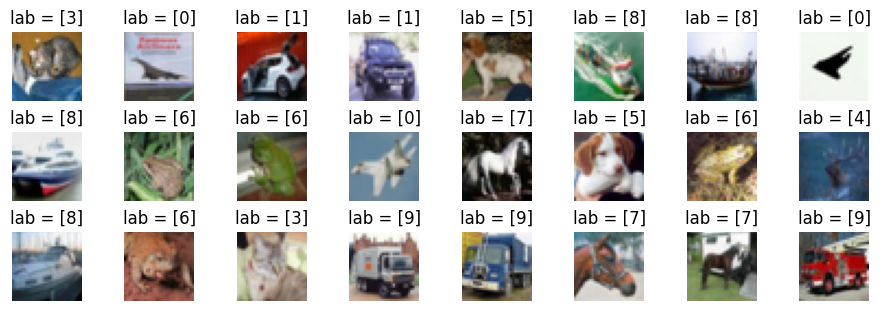

In [5]:
def affiche_24images_lab(img_set, lab_set):
  ncol_aff = 8
  nrow_aff = 3
  fig, axs = plt.subplots(ncols=ncol_aff, nrows=nrow_aff, figsize=(9,3), layout="constrained")
  for no_im in range(ncol_aff*nrow_aff):
    i = int(no_im%nrow_aff)
    j = int(no_im/nrow_aff)
    axs[i,j].set_title(f'lab = {lab_set[no_im]}')
    axs[i,j].imshow(img_set[no_im])
    axs[i,j].axis('off')
  plt.show()

affiche_24images_lab(img_test, lab_test)

In [6]:
def plot_history(Hist):
  fig = plt.figure(1)
# summarize history for accuracy
  fig.add_subplot(1,2,1)
  plt.plot(Hist['accuracy'])
  plt.plot(Hist['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
  fig.add_subplot(1,2,2)
  plt.plot(Hist['loss'])
  plt.plot(Hist['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [7]:
def make_model_1():
  model_cnn = tf.keras.models.Sequential([
   # tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform'),
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3), kernel_initializer='he_uniform', name='Conv2D_1'),
    tf.keras.layers.MaxPooling2D((3,3), name='MaxPool_1'),
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_2'),
    tf.keras.layers.MaxPooling2D((3,3), name='MaxPool_2'),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='Dense_1'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform', name='Dense_2')
  ])
  assert model_cnn.output_shape == (None, 10)
  return model_cnn

model_cnn_1 = make_model_1()
model_cnn_1.summary()

# print(f' model_cnn.trainable_variables : {model_cnn.trainable_variables}')

image = np.copy(img_train[0])
print(image.shape, image[np.newaxis, ...].shape)
decision = model_cnn_1.predict(image[np.newaxis, ...])
print (decision)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 10, 10, 16)        0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 10, 10, 16)        2320      
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 3, 3, 16)          0         
                                                                 
 Flatten (Flatten)           (None, 144)               0         
                                                                 
 Dense_1 (Dense)             (None, 128)               18560     
                                                                 
 Dense_2 (Dense)             (None, 10)                1

In [9]:
reload = 1
if (reload):
  # Loads the weights
  model_cnn_1 = tf.keras.models.load_model('model_cnn1_25k.h5')
  loss, acc = model_cnn_1.evaluate(img_test, lab_test, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_cnn1 = tf.argmax(model_cnn_1.predict(img_test, batch_size=batch_size),axis=1)
  conf_mat_cnn = tf.math.confusion_matrix(lab_test,predictions_cnn1)
  print(conf_mat_cnn)
else:
  model_cnn_1 = make_model_1()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_cnn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_cnn_1.compile(optimizer=model_optimizer, loss=loss_cnn, metrics=['accuracy'])
  h = model_cnn_1.fit(img_train[...], lab_train, epochs=50, validation_split=0.2)
  History_cnn = h.history
  print(History_cnn.keys())
  plot_history(History_cnn)
  model_cnn_1.save('model_cnn1_25k.h5')
  loss, acc = model_cnn_1.evaluate(img_test, lab_test, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_cnn1 = tf.argmax(model_cnn_1.predict(img_test, batch_size=batch_size),axis=1)
  conf_mat_cnn = tf.math.confusion_matrix(lab_test,predictions_cnn1)
  print(conf_mat_cnn)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 - 2s - loss: 1.2661 - accuracy: 0.5496 - 2s/epoch - 8ms/step
Restored model, accuracy: 54.96000051498413
417/417 [==============================] - 1s 2ms/step
tf.Tensor(
[[567  39  79  10  12  10  22  18 202  41]
 [ 30 649  13  10   3   8  27   8 100 152]
 [ 68  23 430  46  92 137  93  58  33  20]
 [ 21  21 102 258  60 304 118  51  31  34]
 [ 33  18 160  38 384  98 126 107  26  10]
 [ 14  10  94  87  32 593  55  78  19  18]
 [ 10  17  75  39  46  47 706  19  14  27]
 [ 18  15  36  41  73 132  32 586  14  53]
 [ 89  58  15  10   4  11   8   9 756  40]
 [ 47 153  15  12   9  25  23  36 113 567]], shape=(10, 10), dtype=int32)


In [10]:
def ambiguous_classes(conf_mat, th_amb):
  print(conf_mat)
  nb_classes = conf_mat.shape[0]
  conf_mat2 = np.copy(conf_mat)
  tab_amb_cl = np.zeros((nb_classes,3))
  n = 0
  for i in range(nb_classes):
    j2 = -1
    xmax = 0
    for j in range(nb_classes):
      if j!=i:
        x = (conf_mat2[i,j]+conf_mat2[j,i])/(conf_mat2[i,i]+conf_mat2[j,j])
        if (x>xmax):
          j2=j
          xmax = x
    if xmax>th_amb:
      print(f' ambiguous classes : {i} & {j2} -> ambiguity = {xmax*100} %')
      k_min = min(i,j2)
      k_max = max(i,j2)
      nn = 0
      deja = False
      for nn in range(n):
        if (int(tab_amb_cl[nn,0]) == k_min):
          deja = True
      if (deja == False):
        tab_amb_cl[n,0] = k_min
        tab_amb_cl[n,1] = k_max
        tab_amb_cl[n,2] = xmax
        n = n+1
  return tab_amb_cl, n

ambiguous_classes(conf_mat_cnn, 0.25)

tf.Tensor(
[[567  39  79  10  12  10  22  18 202  41]
 [ 30 649  13  10   3   8  27   8 100 152]
 [ 68  23 430  46  92 137  93  58  33  20]
 [ 21  21 102 258  60 304 118  51  31  34]
 [ 33  18 160  38 384  98 126 107  26  10]
 [ 14  10  94  87  32 593  55  78  19  18]
 [ 10  17  75  39  46  47 706  19  14  27]
 [ 18  15  36  41  73 132  32 586  14  53]
 [ 89  58  15  10   4  11   8   9 756  40]
 [ 47 153  15  12   9  25  23  36 113 567]], shape=(10, 10), dtype=int32)
 ambiguous classes : 1 & 9 -> ambiguity = 25.082236842105267 %
 ambiguous classes : 2 & 4 -> ambiguity = 30.95823095823096 %
 ambiguous classes : 3 & 5 -> ambiguity = 45.94594594594595 %
 ambiguous classes : 4 & 2 -> ambiguity = 30.95823095823096 %
 ambiguous classes : 5 & 3 -> ambiguity = 45.94594594594595 %
 ambiguous classes : 9 & 1 -> ambiguity = 25.082236842105267 %


(array([[1.   , 9.   , 0.251],
        [2.   , 4.   , 0.31 ],
        [3.   , 5.   , 0.459],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ]]),
 3)

In [11]:
def make_model_2():
  model_fc = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3), strides=(3,3), kernel_initializer='he_uniform', name='Conv_1'),
    tf.keras.layers.Conv2D(64, kernel_size=(5,5), activation='relu', padding='same', strides=(5,5), kernel_initializer='he_uniform', name='Conv_2'),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform', name='Dense_1'),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='Dense_2'),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name='Dense_3'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform', name='Dense_4')
  ])
  assert model_fc.output_shape == (None, 10)
  return model_fc

model_fc_1 = make_model_2()
model_fc_1.summary()

# print(f' model_cnn.trainable_variables : {model_cnn.trainable_variables}')

image = np.copy(img_train[0])
print(image.shape, image[np.newaxis, ...].shape)
decision = model_fc_1.predict(image[np.newaxis, ...])
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 11, 11, 64)        1792      
                                                                 
 Conv_2 (Conv2D)             (None, 3, 3, 64)          102464    
                                                                 
 Flatten (Flatten)           (None, 576)               0         
                                                                 
 Dense_1 (Dense)             (None, 256)               147712    
                                                                 
 Dense_2 (Dense)             (None, 128)               32896     
                                                                 
 Dense_3 (Dense)             (None, 64)                8256      
                                                                 
 Dense_4 (Dense)             (None, 10)               

In [13]:
reload = 1
if (reload):
  # Loads the weights
  model_fc_1 = tf.keras.models.load_model('model_fc1_25k.h5')
  loss, acc = model_fc_1.evaluate(img_test, lab_test, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_fc1 = tf.argmax(model_fc_1.predict(img_test, batch_size=batch_size),axis=1)
  conf_mat_fc = tf.math.confusion_matrix(lab_test,predictions_fc1)
  print(conf_mat_cnn)
else:
  model_fc_1 = make_model_2()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_fc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_fc_1.compile(optimizer=model_optimizer, loss=loss_fc, metrics=['accuracy'])
  h = model_fc_1.fit(img_train[...], lab_train, epochs=20, validation_split=0.2)
  History_fc = h.history
  print(History_fc.keys())
  plot_history(History_fc)
  model_fc_1.save('model_fc1_25k.h5')
  loss, acc = model_fc_1.evaluate(img_test, lab_test, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_fc1 = tf.argmax(model_fc_1.predict(img_test, batch_size=batch_size),axis=1)
  conf_mat_fc = tf.math.confusion_matrix(lab_test,predictions_fc1)
  print(conf_mat_fc)

ambiguous_classes(conf_mat_fc, 0.25)

313/313 - 2s - loss: 1.3173 - accuracy: 0.5532 - 2s/epoch - 5ms/step
Restored model, accuracy: 55.320000648498535
417/417 [==============================] - 3s 4ms/step
tf.Tensor(
[[567  39  79  10  12  10  22  18 202  41]
 [ 30 649  13  10   3   8  27   8 100 152]
 [ 68  23 430  46  92 137  93  58  33  20]
 [ 21  21 102 258  60 304 118  51  31  34]
 [ 33  18 160  38 384  98 126 107  26  10]
 [ 14  10  94  87  32 593  55  78  19  18]
 [ 10  17  75  39  46  47 706  19  14  27]
 [ 18  15  36  41  73 132  32 586  14  53]
 [ 89  58  15  10   4  11   8   9 756  40]
 [ 47 153  15  12   9  25  23  36 113 567]], shape=(10, 10), dtype=int32)
tf.Tensor(
[[606  34  49  41  17   8  38  13 131  63]
 [ 33 675   8  23   1   4  12   1  60 183]
 [ 69  16 386 121 104  75 145  37  22  25]
 [ 21  19  58 488  34 129 173  17  16  45]
 [ 39  10 140 106 377  42 196  55  15  20]
 [ 12  10  65 312  38 384  99  41  14  25]
 [  6  12  42  86  24  13 772  14   7  24]
 [ 27  26  32 119  68  91  49 509   8  71]
 [10

(array([[1.   , 9.   , 0.268],
        [2.   , 4.   , 0.32 ],
        [3.   , 5.   , 0.506],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   ]]),
 3)

In [22]:
def calc_betP(bbas):
  powerset_card = bbas.shape[1]
  n_classes = int(np.log2(powerset_card))
  n_samples = bbas.shape[0]
  betp = np.zeros((bbas.shape[0],n_classes))
  card = np.zeros(powerset_card)
  # début à coder (~10 lignes)
  for i_sample in range(n_samples):
    bbas_sample = bbas[i_sample]
    for i_class in range(n_classes):
      betP_class = 0
      for i in range(powerset_card):
        if np.bitwise_and(i, 2**i_class) != 0:
          betP_class += (1/i.bit_count()) * bbas_sample[i]

      betp[i_sample, i_class] = betP_class

  # fin à coder
  return betp

powerset_card = 1024
bbas2 = np.ones((1,powerset_card))
bbas2 = bbas2/powerset_card
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

bbas2 = np.zeros((1,powerset_card))
bbas2[0,powerset_card-1]=1
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

bbas2 = np.ones((1,powerset_card))
i = 3
i_in = np.zeros(powerset_card)
for j in range(powerset_card):
  i_in[j] = np.bitwise_and(j,2**i)/2**i
print(i_in)
bbas2[0,:] = i_in/(powerset_card/2)
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

bbas2 = np.zeros((1,2**3))
prob = [[0.1, 0.5, 0.4]]
print(f' prob = {prob}')
i = 2**3-1
bbas2[0,i] = 0.1*3
j = 0
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.4-0.1)*2
j = 2
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.5-0.4)*1
print(f' mass = {bbas2}')
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

bbas2 = np.zeros((1,powerset_card))
prob = [[0.1, 0.01, 0.2, 0.11, 0.01, 0.01, 0.4, 0.1, 0.05, 0.01]]
print(f' prob = {prob}')
i = powerset_card-1
bbas2[0,i] = 0.01*10
j = 9
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.01-0.01)*9
j = 5
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.01-0.01)*8
j = 4
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.01-0.01)*7
j = 1
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.05-0.01)*6
j = 8
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.1-0.05)*5
j = 7
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.1-0.1)*4
j = 0
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.11-0.1)*3
j = 3
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.2-0.11)*2
j = 2
i = np.bitwise_xor(i,2**j)
bbas2[0,i] = (0.4-0.2)*1
print(f' sum masses = {np.sum(bbas2, axis=1)}')
print(f' betP = {calc_betP(bbas2)}')

 sum masses = [1.]
 betP = [[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
 sum masses = [1.]
 betP = [[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
[0. 0. 0. ... 1. 1. 1.]
 sum masses = [1.]
 betP = [[0.089 0.089 0.089 0.2   0.089 0.089 0.089 0.089 0.089 0.089]]
 prob = [[0.1, 0.5, 0.4]]
 mass = [[0.  0.  0.1 0.  0.  0.  0.6 0.3]]
 sum masses = [1.]
 betP = [[0.1 0.5 0.4]]
 prob = [[0.1, 0.01, 0.2, 0.11, 0.01, 0.01, 0.4, 0.1, 0.05, 0.01]]
 sum masses = [1.]
 betP = [[0.1  0.01 0.2  0.11 0.01 0.01 0.4  0.1  0.05 0.01]]


In [29]:
def verif_mass(bbas):
  sum = np.sum(bbas,axis=1)
  return sum

def alloc_consonant_bba(predictions):
  predicts = np.copy(predictions)
  n_samples = predictions.shape[0]
  n_classes = predictions.shape[1]
  powerset_card = 2**n_classes
  bbas = np.zeros((n_samples,powerset_card))
  for n in range(n_samples):
    # début à coder (~15 lignes)
    score = []
    H_j = 2**n_classes - 1

    i_j = np.argmin(predicts[n])
    score.append(predicts[n, i_j])

    bbas[n, H_j] = score[0] * n_classes

    for j in range(1, n_classes):
      i_j_1 = i_j
      predicts[n, i_j] = 2
      i_j = np.argmin(predicts[n])
      score.append(predicts[n, i_j])

      H_j = np.bitwise_xor(H_j, 2**i_j_1)

      bbas[n, H_j] += (score[j] - score[j-1]) * (n_classes - j)

    # fin à coder
  return bbas

predictions_cnn1 = model_cnn_1.predict(img_test[:5])
print(f' predictions = {predictions_cnn1}')
bbas_cnn1 = alloc_consonant_bba(predictions_cnn1)
print(f' betP = {calc_betP(bbas_cnn1)}')

1/1 [==============================] - 0s 110ms/step
 predictions = [[0.044 0.023 0.066 0.448 0.015 0.295 0.066 0.006 0.022 0.015]
 [0.336 0.44  0.    0.    0.    0.    0.    0.    0.171 0.052]
 [0.182 0.137 0.004 0.003 0.001 0.001 0.001 0.001 0.513 0.158]
 [0.245 0.211 0.003 0.001 0.    0.    0.002 0.    0.472 0.065]
 [0.    0.    0.08  0.046 0.41  0.019 0.442 0.001 0.    0.   ]]
 betP = [[0.044 0.023 0.066 0.448 0.015 0.295 0.066 0.006 0.022 0.015]
 [0.336 0.44  0.    0.    0.    0.    0.    0.    0.171 0.052]
 [0.182 0.137 0.004 0.003 0.001 0.001 0.001 0.001 0.513 0.158]
 [0.245 0.211 0.003 0.001 0.    0.    0.002 0.    0.472 0.065]
 [0.    0.    0.08  0.046 0.41  0.019 0.442 0.001 0.    0.   ]]


In [36]:
def conjunctive_rule(bbas1, bbas2):
  if bbas2.shape[1] != bbas1.shape[1]:
    return np.zeros((1,1))
  else:
    powerset_card = bbas1.shape[1]
    n_classes = int(np.log2(powerset_card))
    n_samples = min(bbas1.shape[0], bbas2.shape[0])
    bbas12 = np.zeros((n_samples,powerset_card))
    # début à coder (4 lignes)
    for i_sample in range(n_samples):
      for i_1 in range(2**n_classes):
        for i_2 in range(2**n_classes):
          intersection = np.bitwise_and(i_1, i_2)
          bbas12[i_sample, intersection] += bbas1[i_sample, i_1] * bbas2[i_sample, i_2]

    # fin à coder
  return bbas12

print(f' betP = {calc_betP(bbas_cnn1)}')
bbas_cnn1_conj = conjunctive_rule(bbas_cnn1, bbas_cnn1)
print(f' mass sum = {verif_mass(bbas_cnn1_conj)}')
print(f' betP = {calc_betP(bbas_cnn1_conj)}')


 betP = [[0.044 0.023 0.066 0.448 0.015 0.295 0.066 0.006 0.022 0.015]
 [0.336 0.44  0.    0.    0.    0.    0.    0.    0.171 0.052]
 [0.182 0.137 0.004 0.003 0.001 0.001 0.001 0.001 0.513 0.158]
 [0.245 0.211 0.003 0.001 0.    0.    0.002 0.    0.472 0.065]
 [0.    0.    0.08  0.046 0.41  0.019 0.442 0.001 0.    0.   ]]
1024
 mass sum = [1. 1. 1. 1. 1.]
 betP = [[0.015 0.005 0.03  0.596 0.002 0.314 0.031 0.    0.005 0.002]
 [0.344 0.542 0.    0.    0.    0.    0.    0.    0.103 0.011]
 [0.133 0.078 0.    0.    0.    0.    0.    0.    0.686 0.102]
 [0.211 0.159 0.    0.    0.    0.    0.    0.    0.613 0.018]
 [0.    0.    0.028 0.01  0.449 0.002 0.511 0.    0.    0.   ]]


In [37]:
# première fusion : juste les classifieurs 10 classes
nb_samples = 100
sample_0 = 000
nb_lab = 10
lab_b = tf.one_hot(lab_test[sample_0:sample_0+nb_samples,0], nb_lab)

scores_cnn1 = model_cnn_1.predict(img_test[sample_0:sample_0+nb_samples])
bbas_cnn1 = alloc_consonant_bba(scores_cnn1)

scores_fc1 = model_fc_1.predict(img_test[sample_0:sample_0+nb_samples])
bbas_fc1 = alloc_consonant_bba(scores_fc1)

bbas_cnn1_conj_fc1 = conjunctive_rule(bbas_cnn1, bbas_fc1)
betP_cnn1_conj_fc1 = calc_betP(bbas_cnn1_conj_fc1)
dec_b_cnn1_conj_fc1 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1,axis=1), nb_lab)

acc_cnn1_conj_fc1 = np.sum(lab_b*dec_b_cnn1_conj_fc1)/(nb_samples)
print(f' acc_cnn1_conj_fc1 = {acc_cnn1_conj_fc1}')

loss_cnn1s, acc_cnn1s = model_cnn_1.evaluate(img_test[sample_0:sample_0+nb_samples], lab_test[sample_0:sample_0+nb_samples], verbose=2)
print(f' acc_cnn1s = {acc_cnn1s}')
loss_fc1s, acc_fc1s = model_fc_1.evaluate(img_test[sample_0:sample_0+nb_samples], lab_test[sample_0:sample_0+nb_samples], verbose=2)
print(f' acc_fc1s = {acc_fc1s}')

4/4 [==============================] - 0s 40ms/step
1024


KeyboardInterrupt: 

In [ ]:
(img_train_full, label_train_full), (img_test_full, label_test_full) = tf.keras.datasets.cifar10.load_data()

label_val35 = [3,5]
label_val19 = [1,9]
label_val24 = [2,4]

indexes_train_full35, indexes_test35 = select_labels(label_val35, label_train_full, label_test_full)
indexes_train_full24, indexes_test24 = select_labels(label_val24, label_train_full, label_test_full)
indexes_train_full19, indexes_test19 = select_labels(label_val19, label_train_full, label_test_full)
print(indexes_train_full35.shape, indexes_train_full24.shape, indexes_train_full19.shape)

img_train35 = img_train_full[indexes_train_full35]
lab_train35 = label_train_full[indexes_train_full35]
# print(img_train_full.shape, img_train35.shape, lab_train35.shape, img_train19.shape, lab_train19.shape)
img_test35 = img_test_full[indexes_test35]
lab_test35 = label_test_full[indexes_test35]
labels_dichotomize(label_val35, lab_train35, lab_test35)
print(f' {img_train35.shape} {lab_train35.shape} {img_test35.shape} {lab_test35.shape}')

img_train24 = img_train_full[indexes_train_full24]
lab_train24 = label_train_full[indexes_train_full24]
img_test24 = img_test_full[indexes_test24]
lab_test24 = label_test_full[indexes_test24]
labels_dichotomize(label_val24, lab_train24, lab_test24)
print(f' {img_train24.shape} {lab_train24.shape} {img_test24.shape} {lab_test24.shape}')

img_train19 = img_train_full[indexes_train_full19]
lab_train19 = label_train_full[indexes_train_full19]
img_test19 = img_test_full[indexes_test19]
lab_test19 = label_test_full[indexes_test19]
labels_dichotomize(label_val19, lab_train19, lab_test19)
print(f' {img_train19.shape} {lab_train19.shape} {img_test19.shape} {lab_test19.shape}')

del(img_train_full)
del(label_train_full)
del(img_test_full)
del(label_test_full)
gc.collect()

batch_size = 24
affiche_24images_lab(img_train35, lab_train35)
affiche_24images_lab(img_train24, lab_train24)
affiche_24images_lab(img_train19, lab_train19)

# Normalize pixel values between 0 and 1
img_train35 = img_train35.astype('float32') / 255.0
img_train24 = img_train24.astype('float32') / 255.0
img_train19 = img_train19.astype('float32') / 255.0
img_test35 = img_test35.astype('float32') / 255.0
img_test24 = img_test24.astype('float32') / 255.0
img_test19 = img_test19.astype('float32') / 255.0

In [ ]:
def make_dichotomizer_1():
  model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3), kernel_initializer='he_uniform', name='Conv2D_1'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_3'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((3,3), name='MaxPool_1'),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_4'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((3,3), name='MaxPool_2'),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='Conv2D_5'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='Dense_1'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name='Dense_2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='Dense_3')
  ])
  assert model_cnn.output_shape == (None, 2)
  return model_cnn

model_dichoto = make_dichotomizer_1()
model_dichoto.summary()

In [ ]:
reload = 0
if (reload):
  # Loads the weights
  model_dichoto_35 = tf.keras.models.load_model('sample_data/model_di35_25k.h5')
  loss, acc = model_dichoto_35.evaluate(img_test35, lab_test35, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_di35 = tf.argmax(model_dichoto_35.predict(img_test35, batch_size=batch_size),axis=1)
  conf_mat_di35 = tf.math.confusion_matrix(lab_test35, predictions_di35)
  print(conf_mat_di35)
else:
  model_dichoto_35 = make_dichotomizer_1()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_dicho = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_dichoto_35.compile(optimizer=model_optimizer, loss=loss_dicho, metrics=['accuracy'])
  h = model_dichoto_35.fit(img_train35, lab_train35, epochs=100, validation_split=0.2)
  History_di35 = h.history
  print(History_di35.keys())
  plot_history(History_di35)
  model_dichoto_35.save('model_di35_25k.h5')
  loss, acc = model_dichoto_35.evaluate(img_test35, lab_test35, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_di35 = tf.argmax(model_dichoto_35.predict(img_test35, batch_size=batch_size),axis=1)
  conf_mat_di35 = tf.math.confusion_matrix(lab_test35, predictions_di35)
  print(conf_mat_di35)

In [ ]:
reload = 0
if (reload):
  # Loads the weights
  model_dichoto_24 = tf.keras.models.load_model('sample_data/model_di24_25k.h5')
  loss, acc = model_dichoto_24.evaluate(img_test24, lab_test24, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_di24 = tf.argmax(model_dichoto_24.predict(img_test24, batch_size=batch_size),axis=1)
  conf_mat_di24 = tf.math.confusion_matrix(lab_test24, predictions_di24)
  print(conf_mat_di24)
else:
  model_dichoto_24 = make_dichotomizer_1()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_dicho = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_dichoto_24.compile(optimizer=model_optimizer, loss=loss_dicho, metrics=['accuracy'])
  h = model_dichoto_24.fit(img_train24, lab_train24, epochs=100, validation_split=0.2)
  History_di24 = h.history
  print(History_di24.keys())
  plot_history(History_di24)
  model_dichoto_24.save('model_di24_25k.h5')
  loss, acc = model_dichoto_24.evaluate(img_test24, lab_test24, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_di24 = tf.argmax(model_dichoto_24.predict(img_test24, batch_size=batch_size),axis=1)
  conf_mat_di24 = tf.math.confusion_matrix(lab_test24, predictions_di24)
  print(conf_mat_di24)

In [ ]:
reload = 0
if (reload):
  # Loads the weights
  model_dichoto_19 = tf.keras.models.load_model('sample_data/model_di19_25k.h5')
  loss, acc = model_dichoto_19.evaluate(img_test19, lab_test19, verbose=2)
  print(f'Restored model, accuracy: {acc*100}')
  predictions_di19 = tf.argmax(model_dichoto_19.predict(img_test19, batch_size=batch_size),axis=1)
  conf_mat_di19 = tf.math.confusion_matrix(lab_test19, predictions_di19)
  print(conf_mat_di19)
else:
  model_dichoto_19 = make_dichotomizer_1()
  model_optimizer = tf.keras.optimizers.Adam(1e-4)
  loss_dicho = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model_dichoto_19.compile(optimizer=model_optimizer, loss=loss_dicho, metrics=['accuracy'])
  h = model_dichoto_19.fit(img_train19, lab_train19, epochs=100, validation_split=0.2)
  History_di19 = h.history
  print(History_di19.keys())
  plot_history(History_di19)
  model_dichoto_19.save('model_di19_25k.h5')
  loss, acc = model_dichoto_19.evaluate(img_test19, lab_test19, verbose=2)
  print(f' Model, accuracy: {acc*100}')
  predictions_di19 = tf.argmax(model_dichoto_19.predict(img_test19, batch_size=batch_size),axis=1)
  conf_mat_di19 = tf.math.confusion_matrix(lab_test19, predictions_di19)
  print(conf_mat_di19)

In [ ]:
def affiche_bba(bba, nb_lab):
  for k in range(2**nb_lab):
    if (bba[k]>0):
      print(f' k = {np.binary_repr(k,nb_lab)}, m(k) = {bba[k]}')

def discount_bbas(bbas, alpha):
  powerset_card = 2**n_classes
  # print(f' n_samples = {n_samples}, n_classes = {n_classes}, powerset_card = {powerset_card}')
  bbas = bbas*alpha
  bbas[:,powerset_card-1] = bbas[:,powerset_card-1]+1-alpha
  print(verif_mass(bbas))
  return bbas

# correction des bbas 10 classes pour les classes ambigues
def merge_2cl_bbas(bbas,nb_lab,i,j):
  # début à coder (4 lignes)

  # fin à coder
  return bbas

def alloc_dichoto_bba(predictions, n_classes, label_val):
  predicts = np.copy(predictions)
  n_samples = predictions.shape[0]
  powerset_card = 2**n_classes
  bbas = np.zeros((n_samples,powerset_card))
  for n in range(n_samples):
  # début à coder (4 lignes)

  # fin à coder
  return bbas

n_classes = 10
predictions_di35 = model_dichoto_35.predict(img_test35[:5])
print(f' predictions = {predictions_di35}')
bbas_di35 = alloc_dichoto_bba(predictions_di35, n_classes, label_val35)
print(f' betP = {calc_betP(bbas_di35)}')
predictions_di19 = model_dichoto_19.predict(img_test19[:5])
print(f' predictions = {predictions_di19}')
bbas_di19 = alloc_dichoto_bba(predictions_di19, n_classes, label_val19)
print(f' betP = {calc_betP(bbas_di19)}')
affiche_bba(bbas_di19[0], nb_lab)

alpha = 0.2
print(f' alpha = {alpha} => {discount_bbas(bbas_di19, alpha)}')
affiche_bba(discount_bbas(bbas_di19, alpha)[0], nb_lab)

In [ ]:
nb_samples = 1000
sample_0 = 000
nb_lab = 10
lab_b = tf.one_hot(lab_test[sample_0:sample_0+nb_samples,0], nb_lab)

loss_cnn1s, acc_cnn1s = model_cnn_1.evaluate(img_test[sample_0:sample_0+nb_samples], lab_test[sample_0:sample_0+nb_samples], verbose=2)
print(f' acc_cnn1s = {acc_cnn1s}')
scores_cnn1 = model_cnn_1.predict(img_test[sample_0:sample_0+nb_samples])
bbas_cnn1 = alloc_consonant_bba(scores_cnn1)

loss_fc1s, acc_fc1s = model_fc_1.evaluate(img_test[sample_0:sample_0+nb_samples], lab_test[sample_0:sample_0+nb_samples], verbose=2)
print(f' acc_fc1s = {acc_fc1s}')
scores_fc1 = model_fc_1.predict(img_test[sample_0:sample_0+nb_samples])
bbas_fc1 = alloc_consonant_bba(scores_fc1)

bbas_cnn1_conj_fc1 = conjunctive_rule(bbas_cnn1, bbas_fc1)
betP_cnn1_conj_fc1 = calc_betP(bbas_cnn1_conj_fc1)
dec_b_cnn1_conj_fc1 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1,axis=1), nb_lab)
acc_cnn1_conj_fc1 = np.sum(lab_b*dec_b_cnn1_conj_fc1)/(nb_samples)
print(f' acc_cnn1_conj_fc1 = {acc_cnn1_conj_fc1}')

bbas_cnn1b = merge_2cl_bbas(bbas_cnn1,nb_lab,int(label_val35[0]),int(label_val35[1]))
bbas_cnn1c = merge_2cl_bbas(bbas_cnn1b,nb_lab,int(label_val24[0]),int(label_val24[1]))
bbas_cnn1d = merge_2cl_bbas(bbas_cnn1c,nb_lab,int(label_val19[0]),int(label_val19[1]))
bbas_fc1b = merge_2cl_bbas(bbas_fc1,nb_lab,int(label_val35[0]),int(label_val35[1]))
bbas_fc1c = merge_2cl_bbas(bbas_fc1b,nb_lab,int(label_val24[0]),int(label_val24[1]))
bbas_fc1d = merge_2cl_bbas(bbas_fc1c,nb_lab,int(label_val19[0]),int(label_val19[1]))
# alpha = 0.1
bbas_cnn1_conj_fc1 = conjunctive_rule(bbas_cnn1d, bbas_fc1d)

predictions_di35 = model_dichoto_35.predict(img_test[sample_0:sample_0+nb_samples])
bbas_di35 = alloc_dichoto_bba(predictions_di35, nb_lab, label_val35)
predictions_di24 = model_dichoto_24.predict(img_test[sample_0:sample_0+nb_samples])
bbas_di24 = alloc_dichoto_bba(predictions_di24, nb_lab, label_val24)
predictions_di19 = model_dichoto_19.predict(img_test[sample_0:sample_0+nb_samples])
bbas_di19 = alloc_dichoto_bba(predictions_di19, nb_lab, label_val19)

debug = 0
if debug:
  bbas_cnn1_conj_fc1_di35 = conjunctive_rule(bbas_di35, bbas_cnn1_conj_fc1)
  betP_cnn1_conj_fc1_di35 = calc_betP(bbas_cnn1_conj_fc1_di35)
  dec_b_cnn1_conj_fc1_di35 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1_di35,axis=1), nb_lab)
  acc_cnn1_conj_fc1_di35 = np.sum(lab_b*dec_b_cnn1_conj_fc1_di35)/(nb_samples)
  print(f' acc_cnn1_conj_fc1_di35 = {acc_cnn1_conj_fc1_di35}')
  bbas_cnn1_conj_fc1_di19 = conjunctive_rule(bbas_di19, bbas_cnn1_conj_fc1)
  betP_cnn1_conj_fc1_di19 = calc_betP(bbas_cnn1_conj_fc1_di19)
  dec_b_cnn1_conj_fc1_di19 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1_di19,axis=1), nb_lab)
  acc_cnn1_conj_fc1_di19 = np.sum(lab_b*dec_b_cnn1_conj_fc1_di19)/(nb_samples)
  print(f' acc_cnn1_conj_fc1_di19 = {acc_cnn1_conj_fc1_di19}')

bbas_cnn1_conj_fc1_di35 = conjunctive_rule(bbas_di35, bbas_cnn1_conj_fc1)
bbas_cnn1_conj_fc1_di35_di24 = conjunctive_rule(bbas_di24, bbas_cnn1_conj_fc1_di35)
bbas_cnn1_conj_fc1_di35_di24_di19 = conjunctive_rule(bbas_di19, bbas_cnn1_conj_fc1_di35_di24)
betP_cnn1_conj_fc1_di35_di24_di19 = calc_betP(bbas_cnn1_conj_fc1_di35_di24_di19)
dec_b_cnn1_conj_fc1_di35_di24_di19 = tf.one_hot(tf.argmax(betP_cnn1_conj_fc1_di35_di24_di19,axis=1), nb_lab)
acc_cnn1_conj_fc1_di35_di24_di19 = np.sum(lab_b*dec_b_cnn1_conj_fc1_di35_di24_di19)/(nb_samples)
print(f' acc_cnn1_conj_fc1_di35_di24_di19 = {acc_cnn1_conj_fc1_di35_di24_di19}')